# Linear Least Squares

### Imports

To keep things simple, we are only using numpy for mathematical operations and scikit-learn 
for trivial machine-learning operations (downloading data sets, splitting data sets in train and test sets, etc.)

In [1]:
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

# for polynomial interpolation
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

# for 3D plots, otherwise unused
from mpl_toolkits.mplot3d import Axes3D

# for MNIST digits dataset
from sklearn.datasets import fetch_mldata
# for splitting datasets
from sklearn.model_selection import train_test_split

### Inverting a possibly singular matrix

One could use the [Moore-Penrose pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse), however this requires knowledge of [singular value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition).

Therefore, we are using a simpler pseudoinverse. Let $A \in Mat_{n \times n}$ be a possibly singular symmetric matrix, $I \in Mat_{n \times n}$ be the identity matrix and $\epsilon > 0$.
For any matrix, we observe:

$det(A - I\epsilon) = 0 \iff Eig(A, \epsilon) \neq \emptyset$

As $A$ in our case is $X^TX$, it is a symmetric positive semidefinite matrix, therefore it
has only non-negative eigenvalues. Therefore, we could safely assume

$det(A + I\epsilon) \neq 0$


**Bottom line:** we are taking the inverse of $A + I\epsilon$ instead of the inverse of $A$ within our least squares
esmitator.


### Least squares

Minimizing the squared error $(X^Tw - y)^2$ we arrive at the least squares equation $w = (X^TX)^{-1}X^Ty$

In [2]:
class LinearRegression:
    def __init__(self):
        self.w = None  # weights
        
    def transform(self, X):
        # add ones as the last column of X
        return np.column_stack((X, np.ones(X.shape[0])))
    
    def fit(self, X, y, epsilon=1e-6):
        X = self.transform(X)
        # least squares estimation of weights
        self.w = np.linalg.inv(X.T.dot(X) + np.eye(X.shape[1])*epsilon).dot(X.T).dot(y)
        
    def predict(self, X):
        if self.w is None:
            raise Exception('Train first!')
        
        X = self.transform(X)
        return X.dot(self.w)
    
    def evaluate(self, X, y):
        """Return mean squared error (MSE) for Dataset X and expectations y"""
        prediction = self.predict(X)
        e = prediction - y
        MSE = e.dot(e) / y.shape[0]
        
        return MSE

## Visualizing least squares in 2D and 3D

#### Experiment functions

**2D:** $f_1(x) = \frac{3}{2}x + 2$.

**3D:** $f_2((x, y)) = \frac{3}{2}x + \frac{1}{2}y + 2$

#### Experiment observations

Often in machine learning, we assume we observe the result of a function with some measurement error.
The measurement error can be thought of as gaussian noise, a value sampled from a gaussian distribution.
For this experiment, we pick the gaussian distribution to have mean 0 and variance 1. (I.e. $\mu = 0, \sigma^{2} = 1$

**2D:** $\hat{f_1(x)} = f_1(x) + \mathcal{N}(\mu,\,\sigma^{2})$

**3D:** $\hat{f_2((x,y))} = f_2((x,y)) + \mathcal{N}(\mu,\,\sigma^{2})$

In [3]:
f_1 = lambda x: (3/2)*x + 2
f_2 = lambda x: x.dot(np.array([3/2, -1/2])) + 2
f_1_hat = lambda x: f_1(x) + np.random.normal(0, 1, x.shape[0])
f_2_hat = lambda x: f_2(x) + np.random.normal(0, 1, x.shape[0])

#### 2D

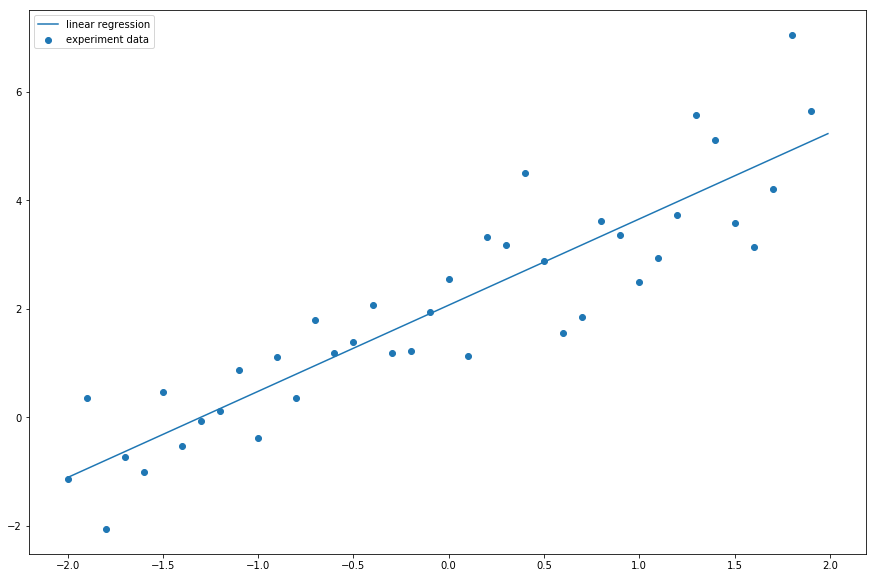

In [4]:
def run_experiment_2d():
    x = np.arange(-2, 2, 0.1)
    x_axis = np.arange(-2, 2, 0.01)
    y = f_1_hat(x)

    lr = LinearRegression()
    lr.fit(x, y)

    fig = plt.figure(figsize=(15,10))
    plt.scatter(x, y, label='experiment data')
    plt.plot(x_axis, lr.predict(x_axis), label='linear regression')
    plt.legend()
    plt.show()
    
run_experiment_2d()
del run_experiment_2d

#### 3D

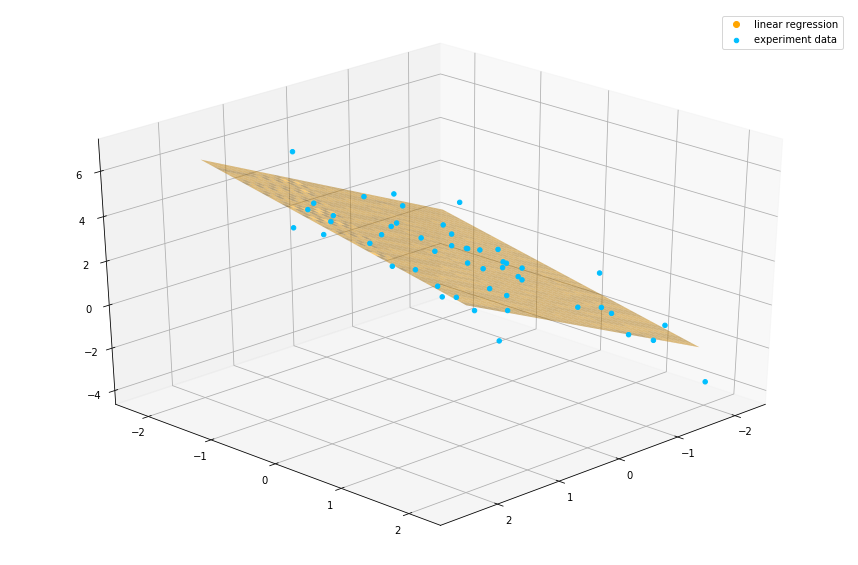

In [5]:
%matplotlib inline

def run_experiment_3d():

    # generate plot
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')


    # random points in 2d
    X = np.random.randn(2, 50).T

    # generate experiment and plot
    y = f_2_hat(X)
    experiment = ax.scatter(X[:,0], X[:,1], y, color='deepskyblue', alpha=1)

    # train linear regression
    lr = LinearRegression()
    lr.fit(X, y)


    # create a mesh of points (the surface of all x and z values)
    x = z = np.arange(-2.0, 2.0, 0.1)
    X, Z = np.meshgrid(x, z)

    # turn the mesh into a matrix where each row is a point in 2D
    X_ = np.array([np.array([x,y]) for x,y in zip(np.ravel(X), np.ravel(Z))])

    # use the trained LLS to predict Y values for these points
    prediction = lr.predict(X_)

    # turn prediction into a mesh of points again
    Y = prediction.reshape(X.shape)

    # plot the resulting surface
    ax.plot_surface(X, Z, Y, color='orange', alpha=.5)

    # surface plots don't support labels, so create a fake line to fake it
    fake2Dline = mpl.lines.Line2D([0],[0], linestyle="none", c='orange', marker = 'o')

    # show legend
    ax.legend([fake2Dline, experiment], ['linear regression', 'experiment data'], numpoints = 1)

    # pick a fancy initial plot angle
    ax.view_init(30, 45)
    
run_experiment_3d()
del run_experiment_3d

## Polynomial approximation

Linear regression is only linear in the space of the trainable parameters. However, we could apply non-linear transformations to our initial data set, resulting in non-linear estimation on the original data set.

Let's first construct our PolynomialApproximator applying this logic

In [6]:
class PolynomialApproximator(LinearRegression):
    def __init__(self, deg=2):
        self.deg = deg
        super().__init__()
    
    def transform(self, X):
        # calculate x, x^2, ..., x^n in degs
        degs = [X]
        for i in range(2, self.deg + 1):
            # NOTE: we want X^n, therefore this is component-wise multiplication
            #       and not a matrix multiplication
            degs.append(degs[-1] * X )
        
        # add x^n, ..., x^2
        X = np.column_stack(degs[::-1])
        
        return super().transform(X)    

### 2D example

We are going to look at a 2D example of polynomial approximation and compare it to the results using polynomial interpolation.

We are going to look at the following two functions in particular:

$g(x) = x^3 + 4x^2 - 3x - 5$

$\hat{g(x)} = g(x) + \mathcal{N}(\mu,\,\sigma^{2})$ for $\mu=0$, $\sigma^{2} = 1$

In [7]:
g_x = lambda x: np.polyval([-1, 4, -3, -5], x)
get_noisy = lambda x: x + np.random.normal(0, 1, x.shape[0])

Number of data points:  50


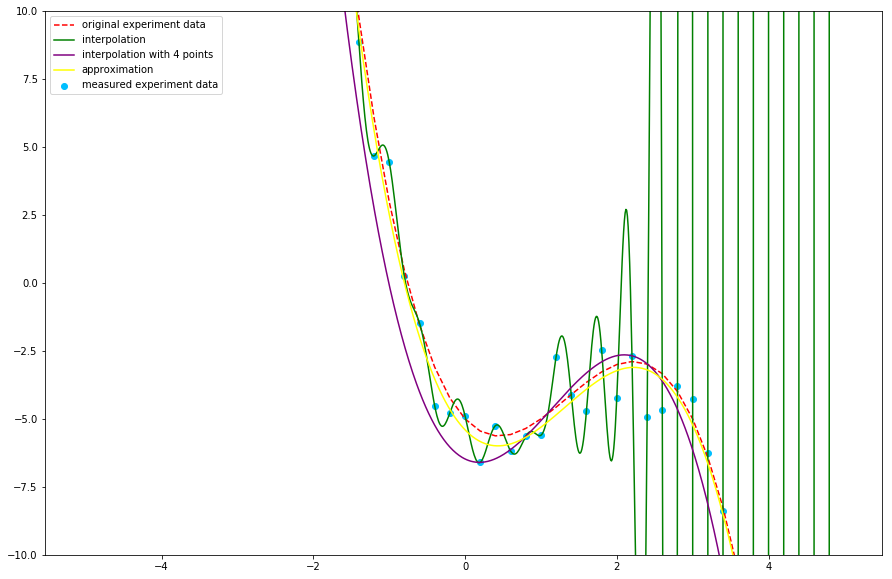

In [8]:
def run_experiment():
    # seed numpy random number generator for reproducable output
    np.random.seed(42)

    X = np.arange(-5, 5, .2)
    y_orig = g_x(X)
    y = get_noisy(y_orig)
    
    print('Number of data points: ', X.shape[0])

    x_vals = np.arange(-5, 5, .01)

    # get lagrange interpolated polynom
    interp_pol = Polynomial(lagrange(X, y)).coef
    yinterp = np.polyval(interp_pol, x_vals)
    
    # get lagrange interpolated polynom using only 4 points
    rand_4 = np.random.permutation(X.shape[0])[:4]
    interp_pol_4 = Polynomial(lagrange(X[rand_4], y[rand_4])).coef
    yinterp4 = np.polyval(interp_pol_4, x_vals)

    # get polynomial approximation with least squares
    pol_appr = PolynomialApproximator(deg=3)
    pol_appr.fit(X, y)
    yappr = pol_appr.predict(x_vals)

    # plot
    plt.figure(figsize=(15,10))

    axes = plt.gca()
    axes.set_ylim([-10, 10])

    plt.plot(X, y_orig, label='original experiment data', color='red', linestyle='--')
    plt.scatter(X, y, label='measured experiment data', color='deepskyblue')
    plt.plot(x_vals, yinterp, label='interpolation', color='green')
    plt.plot(x_vals, yinterp4, label='interpolation with 4 points', color='purple')
    plt.plot(x_vals, yappr, label='approximation', color='yellow')

    plt.legend()
    plt.show()
    
    # print('Interpolation coefficients: ', interp_pol)
    # print('Approximation coefficients: ', pol_appr.w)
    # print('Max value interpolation: ', np.max(yinterp))
    
run_experiment()
del run_experiment

## Digit classification with linear regression

#### Load MNIST dataset

NOTE: here each image is represented as a n-dimensional vector. This means, although an image is a matrix of pixel values, thix matrix is reshaped into a vector containing img_widht x img_height entries.

In [9]:
mnist = fetch_mldata('MNIST original', data_home='./datasets/')
X = mnist.data
y = mnist.target
im_side_length = int(np.sqrt(X.shape[1]))
im_shape = (im_side_length, im_side_length)

X.shape, y.shape

/home/hristov/miniconda3/envs/lls/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/hristov/miniconda3/envs/lls/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


((70000, 784), (70000,))

#### Split dataset in train and test datasets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Visualize some data

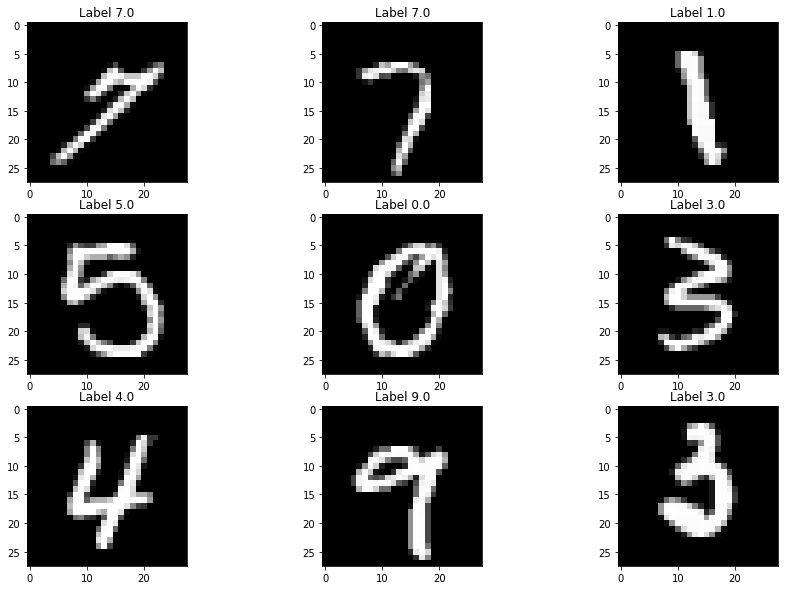

In [11]:
%matplotlib inline

fig = plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(X_train[i].reshape(im_shape), cmap='gray')
    plt.title(f'Label {y_train[i]}')

### Implement linear regression classifier

NOTE: such classifiers are not a good idea, but more on that later on

#### Details

As we are finding a linear separation border, we can only classify (distinguish between) two classes.
Therefore, if we want to classify all digits, we need to build a so called One VS All classification method. That way, we could predict if a digit is more like a zero or more like a one, more lige a zero or more like a two, ...

In [12]:
class BinaryLLSClassifier(LinearRegression):
    def __init__(self):
        super().__init__()
        self.class_labels = []
        
    def _transform_to_classification_labels(self, y):
        y_hat = np.ones(y.shape)
        y_hat[np.where(y == self.class_labels[0])] = -1
        
        return y_hat
        
    def fit(self, X, y, epsilon=1e-6):
        self.class_labels = np.unique(y)
        
        if self.class_labels.shape[0] > 2:
            raise Exception('Only binary cassification allowed! Detected more than 2 class labels')
            
        # transform labels to negative and positive ones
        y = self._transform_to_classification_labels(y)
            
        super().fit(X, y, epsilon=epsilon)
        
    def predict(self, X):
        prediction = super().predict(X)
        classification = np.ones(X.shape[0], dtype=int)
        classification[np.where(prediction < 0)] = 0
        
        return self.class_labels[classification]
    
    def evaluate(self, X, y):
        prediction = self.predict(X)
        correct = np.where(prediction == y)[0]
        
        return (1. * correct.shape[0]) / len(y)

#### Accuracy

In [13]:
def test_binary():

    binary_classifier = BinaryLLSClassifier()

    data_01_idx_train = np.where((y_train == 9) | (y_train == 8))
    data_01_idx_test = np.where((y_test == 9) | (y_test == 8))
    
    X_train_, y_train_ = X_train[data_01_idx_train], y_train[data_01_idx_train]
    X_test_, y_test_ = X_test[data_01_idx_test], y_test[data_01_idx_test]

    binary_classifier.fit(X_train_, y_train_)
    score = binary_classifier.evaluate(X_train_, y_train_)
    
    print(score)
    
test_binary()
del test_binary

0.9813473379210431


### One VS All Classifier

In [14]:
class LLSOneVSAllClassifier:
    def __init__(self):
        self.class_labels = []
        self.classifiers = []
        
    def _get_data_for_i_vs_j(self, i, j, X, y=np.array([])):
        take_idx = np.where((y == i) | (y == j))
        
        return X[take_idx], y[take_idx]
        
    def _get_classifier_i_vs_j(self, i, j):
        i, j = min(i, j), max(i, j)
        
        return self.classifiers[i][j]
        
    def _fit_classifiers(self, X, y):
        class_len = self.class_labels.shape[0]
        self.classifiers = [[None] * class_len for i in range(class_len)]
        
        for i, label in enumerate(self.class_labels):
            self.classifiers[-1].append(None)
            for j in range(i + 1, self.class_labels.shape[0]):
                new_classifier = BinaryLLSClassifier()
                new_classifier.fit(*self._get_data_for_i_vs_j(i, j, X, y))
                self.classifiers[i][j] = new_classifier
        
    def fit(self, X, y):
        self.class_labels = np.unique(y)
        self._fit_classifiers(X, y)
        
    def predict(self, X):
        # matrix where each row i is the class scores for data point x_i
        scores = np.zeros((X.shape[0], self.class_labels.shape[0]))
        
        for i, label in enumerate(self.class_labels):
            for j in range(i + 1, self.class_labels.shape[0]):
                
                # vector of predictions i vs j
                prediction_i_vs_j = self._get_classifier_i_vs_j(i, j).predict(X)
                
                # vector score (0 or 1) for each data point and each cassifier
                # i.e. vector number_i has ones on the indexes k, for which prediction(x_k) = class_i
                scores_i = np.zeros(prediction_i_vs_j.shape[0])
                scores_j = np.zeros(prediction_i_vs_j.shape[0])
                
                scores_i[np.where(prediction_i_vs_j == self.class_labels[i])] = 1
                scores_j[np.where(prediction_i_vs_j == self.class_labels[j])] = 1
                
                # add scores to columns for i and j in matrix
                scores[:,i] += scores_i
                scores[:,j] += scores_j
                
        return self.class_labels[scores.argmax(1)]
    
    def evaluate(self, X, y):
        prediction = self.predict(X)
        correct = np.where(prediction == y)[0]
        
        return (1. * correct.shape[0]) / len(y)

#### Accuracy

In [15]:
%%time

def evaluate_classifier():
    classifier = LLSOneVSAllClassifier()
    classifier.fit(X_train, y_train)
    
    accuracy = classifier.evaluate(X_test, y_test)
    print(f'Accuracy: {accuracy}')
    
evaluate_classifier()
del evaluate_classifier

Accuracy: 0.9269285714285714
CPU times: user 1min 18s, sys: 3.49 s, total: 1min 22s
Wall time: 12 s


### Visualize predictions

CPU times: user 1min 12s, sys: 2.64 s, total: 1min 15s
Wall time: 10.8 s


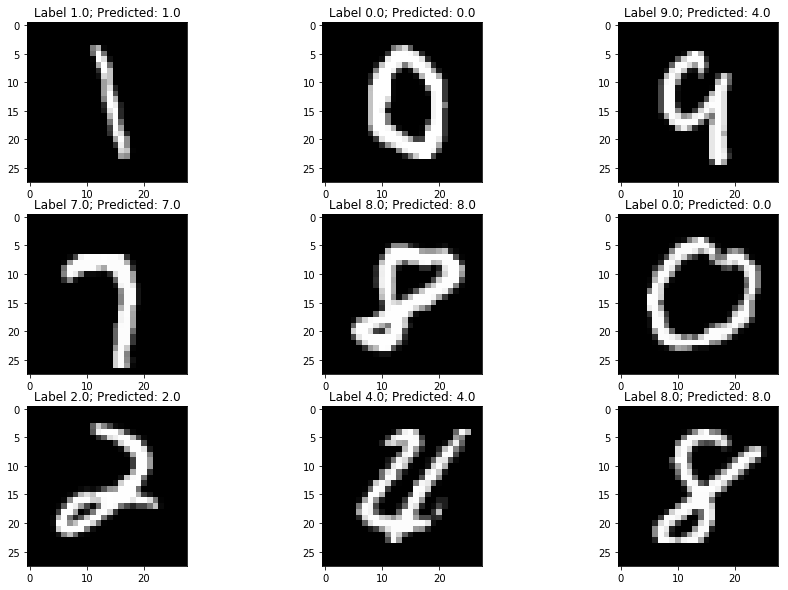

In [16]:
%%time

def present_some_predictions():
    classifier = LLSOneVSAllClassifier()
    classifier.fit(X_train, y_train)
    
    np.random.seed(42)
    random_index = np.random.permutation(y_test.shape[0])[:9]

    predictions = classifier.predict(X_test[random_index])

    fig = plt.figure(figsize=(15,10))
    for nth, i in enumerate(random_index):
        plt.subplot(331 + nth)
        plt.imshow(X_test[i].reshape(im_shape), cmap='gray')
        plt.title(f'Label {y_test[i]}; Predicted: {predictions[nth]}')
    
    
    
present_some_predictions()
del present_some_predictions

### What does the model learn?

Let's see what are the most important features for distinguishing between digits.

Remember, we are multiplying each pixel value with some learned weight, so we can actually transform this weights
into an image and just see which are the "most important pixels"

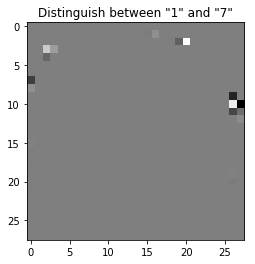

In [17]:
def plot_features_i_vs_j(i, j):
    train_idx = np.where((y_train == i) | (y_train == j))
    X_train_ = X_train[train_idx]
    y_train_ = y_train[train_idx]
    
    classifier = BinaryLLSClassifier()
    classifier.fit(X_train_, y_train_)
    
    plt.title(f'Distinguish between "{i}" and "{j}"')
    plt.imshow(classifier.w[:-1].reshape(im_shape), cmap='gray')
    
plot_features_i_vs_j(1, 7)
del plot_features_i_vs_j

## Why is classification with linear regression not a good idea?

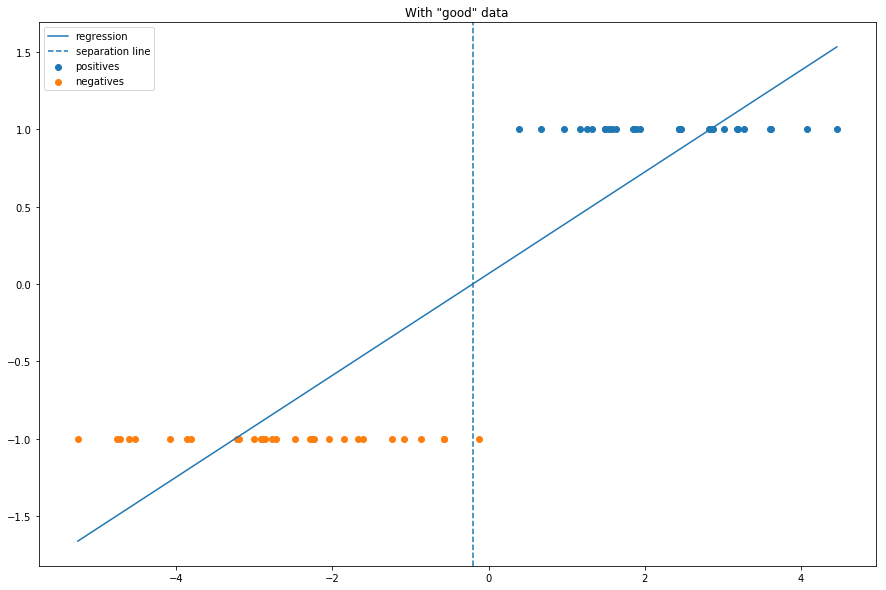

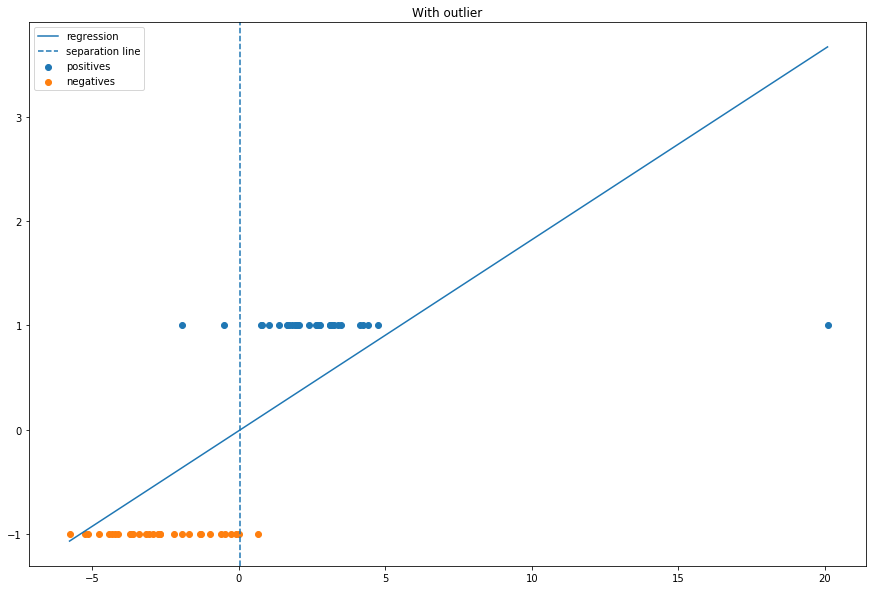

In [18]:
def plot_scenario(title, positive_x, negative_x):
    plt.figure(figsize=(15,10))
    plt.title(title)

    positive_x += np.random.normal(0, 1, positive_x.shape)
    positive_y = np.ones(positive_x.shape)
    negative_x += np.random.normal(0, 1, negative_x.shape)
    negative_y = np.ones(negative_x.shape) * -1
    plt.scatter(positive_x, positive_y, label='positives')
    plt.scatter(negative_x, negative_y, label='negatives')

    lr = LinearRegression()
    lr.fit(np.array([*positive_x, *negative_x]), np.array([*positive_y, *negative_y]))

    X = np.arange(np.min(negative_x), np.max(positive_x), 0.01)
    y = lr.predict(X)
    plt.plot(X, y, label='regression')

    min_y_idx = np.argmin(np.abs(y))
    min_x = X[min_y_idx]
    plt.axvline(x=min_x, linestyle='--', label='separation line')
    
    plt.legend()
        

def visualize_classification():
    np.random.seed(42)
    pos_x = np.arange(1, 4, 0.1)
    neg_x = np.arange(-4, -1, 0.1)
    
    plot_scenario('With "good" data', pos_x, neg_x)
    plot_scenario('With outlier', np.array([*pos_x, 20]), neg_x)

visualize_classification()
del plot_scenario
del visualize_classification